The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install -U mxnet-cu101==1.7.0


# 模型选择、欠拟合和过拟合
:label:`sec_model_selection`

作为机器学习科学家，我们的目标是发现*模式*（pattern）。
但是，我们如何才能确定模型是真正发现了一种泛化的模式，
而不是简单地记住了数据呢？
例如，我们想要在患者的基因数据与痴呆状态之间寻找模式，
其中标签是从集合$\{\text{痴呆}, \text{轻度认知障碍}, \text{健康}\}$中提取的。
因为基因可以唯一确定每个个体（不考虑双胞胎），
所以在这个任务中是有可能记住整个数据集的。

我们不想让模型只会做这样的事情：“那是鲍勃！我记得他！他有痴呆症！”。
原因很简单：当我们将来部署该模型时，模型需要判断从未见过的患者。
只有当模型真正发现了一种泛化模式时，才会作出有效的预测。

更正式地说，我们的目标是发现某些模式，
这些模式捕捉到了我们训练集潜在总体的规律。
如果成功做到了这点，即使是对以前从未遇到过的个体，
模型也可以成功地评估风险。
如何发现可以泛化的模式是机器学习的根本问题。

困难在于，当我们训练模型时，我们只能访问数据中的小部分样本。
最大的公开图像数据集包含大约一百万张图像。
而在大部分时候，我们只能从数千或数万个数据样本中学习。
在大型医院系统中，我们可能会访问数十万份医疗记录。
当我们使用有限的样本时，可能会遇到这样的问题：
当收集到更多的数据时，会发现之前找到的明显关系并不成立。

将模型在训练数据上拟合的比在潜在分布中更接近的现象称为*过拟合*（overfitting），
用于对抗过拟合的技术称为*正则化*（regularization）。
在前面的章节中，有些读者可能在用Fashion-MNIST数据集做实验时已经观察到了这种过拟合现象。
在实验中调整模型架构或超参数时会发现：
如果有足够多的神经元、层数和训练迭代周期，
模型最终可以在训练集上达到完美的精度，此时测试集的准确性却下降了。

## 训练误差和泛化误差

为了进一步讨论这一现象，我们需要了解训练误差和泛化误差。
*训练误差*（training error）是指，
模型在训练数据集上计算得到的误差。
*泛化误差*（generalization error）是指，
模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

问题是，我们永远不能准确地计算出泛化误差。
这是因为无限多的数据样本是一个虚构的对象。
在实际中，我们只能通过将模型应用于一个独立的测试集来估计泛化误差，
该测试集由随机选取的、未曾在训练集中出现的数据样本构成。

下面的三个思维实验将有助于更好地说明这种情况。
假设一个大学生正在努力准备期末考试。
一个勤奋的学生会努力做好练习，并利用往年的考试题目来测试自己的能力。
尽管如此，在过去的考试题目上取得好成绩并不能保证他会在真正考试时发挥出色。
例如，学生可能试图通过死记硬背考题的答案来做准备。
他甚至可以完全记住过去考试的答案。
另一名学生可能会通过试图理解给出某些答案的原因来做准备。
在大多数情况下，后者会考得更好。

类似地，考虑一个简单地使用查表法来回答问题的模型。
如果允许的输入集合是离散的并且相当小，
那么也许在查看许多训练样本后，该方法将执行得很好。
但当这个模型面对从未见过的例子时，它表现的可能比随机猜测好不到哪去。
这是因为输入空间太大了，远远不可能记住每一个可能的输入所对应的答案。
例如，考虑$28\times28$的灰度图像。
如果每个像素可以取$256$个灰度值中的一个，
则有$256^{784}$个可能的图像。
这意味着指甲大小的低分辨率灰度图像的数量比宇宙中的原子要多得多。
即使我们可能遇到这样的数据，我们也不可能存储整个查找表。

最后，考虑对掷硬币的结果（类别0：正面，类别1：反面）进行分类的问题。
假设硬币是公平的，无论我们想出什么算法，泛化误差始终是$\frac{1}{2}$。
然而，对于大多数算法，我们应该期望训练误差会更低（取决于运气）。
考虑数据集{0，1，1，1，0，1}。
我们的算法不需要额外的特征，将倾向于总是预测*多数类*，
从我们有限的样本来看，它似乎是1占主流。
在这种情况下，总是预测类1的模型将产生$\frac{1}{3}$的误差，
这比我们的泛化误差要好得多。
当我们逐渐增加数据量，正面比例明显偏离$\frac{1}{2}$的可能性将会降低，
我们的训练误差将与泛化误差相匹配。

### 统计学习理论

由于泛化是机器学习中的基本问题，
许多数学家和理论家毕生致力于研究描述这一现象的形式理论。
在[同名定理（eponymous theorem）](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem)中，
格里文科和坎特利推导出了训练误差收敛到泛化误差的速率。
在一系列开创性的论文中，
[Vapnik和Chervonenkis](https://en.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_theory)
将这一理论扩展到更一般种类的函数。
这项工作为统计学习理论奠定了基础。

在我们目前已探讨、并将在之后继续探讨的监督学习情景中，
我们假设训练数据和测试数据都是从相同的分布中独立提取的。
这通常被称为*独立同分布假设*（i.i.d. assumption），
这意味着对数据进行采样的过程没有进行“记忆”。
换句话说，抽取的第2个样本和第3个样本的相关性，
并不比抽取的第2个样本和第200万个样本的相关性更强。

要成为一名优秀的机器学习科学家需要具备批判性思考能力。
假设是存在漏洞的，即很容易找出假设失效的情况。
如果我们根据从加州大学旧金山分校医学中心的患者数据训练死亡风险预测模型，
并将其应用于马萨诸塞州综合医院的患者数据，结果会怎么样？
这两个数据的分布可能不完全一样。
此外，抽样过程可能与时间有关。
比如当我们对微博的主题进行分类时，
新闻周期会使得正在讨论的话题产生时间依赖性，从而违反独立性假设。

有时候我们即使轻微违背独立同分布假设，模型仍将继续运行得非常好。
比如，我们有许多有用的工具已经应用于现实，如人脸识别、语音识别和语言翻译。
毕竟，几乎所有现实的应用都至少涉及到一些违背独立同分布假设的情况。

有些违背独立同分布假设的行为肯定会带来麻烦。
比如，我们试图只用来自大学生的人脸数据来训练一个人脸识别系统，
然后想要用它来监测疗养院中的老人。
这不太可能有效，因为大学生看起来往往与老年人有很大的不同。

在接下来的章节中，我们将讨论因违背独立同分布假设而引起的问题。
目前，即使认为独立同分布假设是理所当然的，理解泛化性也是一个困难的问题。
此外，能够解释深层神经网络泛化性能的理论基础，
也仍在继续困扰着学习理论领域最伟大的学者们。

当我们训练模型时，我们试图找到一个能够尽可能拟合训练数据的函数。
但是如果它执行地“太好了”，而不能对看不见的数据做到很好泛化，就会导致过拟合。
这种情况正是我们想要避免或控制的。
深度学习中有许多启发式的技术旨在防止过拟合。

### 模型复杂性

当我们有简单的模型和大量的数据时，我们期望泛化误差与训练误差相近。
当我们有更复杂的模型和更少的样本时，我们预计训练误差会下降，但泛化误差会增大。
模型复杂性由什么构成是一个复杂的问题。
一个模型是否能很好地泛化取决于很多因素。
例如，具有更多参数的模型可能被认为更复杂，
参数有更大取值范围的模型可能更为复杂。
通常对于神经网络，我们认为需要更多训练迭代的模型比较复杂，
而需要*早停*（early stopping）的模型（即较少训练迭代周期）就不那么复杂。

我们很难比较本质上不同大类的模型之间（例如，决策树与神经网络）的复杂性。
就目前而言，一条简单的经验法则相当有用：
统计学家认为，能够轻松解释任意事实的模型是复杂的，
而表达能力有限但仍能很好地解释数据的模型可能更有现实用途。
在哲学上，这与波普尔的科学理论的可证伪性标准密切相关：
如果一个理论能拟合数据，且有具体的测试可以用来证明它是错误的，那么它就是好的。
这一点很重要，因为所有的统计估计都是*事后归纳*。
也就是说，我们在观察事实之后进行估计，因此容易受到相关谬误的影响。
目前，我们将把哲学放在一边，坚持更切实的问题。

本节为了给出一些直观的印象，我们将重点介绍几个倾向于影响模型泛化的因素。

1. 可调整参数的数量。当可调整参数的数量（有时称为*自由度*）很大时，模型往往更容易过拟合。
1. 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
1. 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

## 模型选择

在机器学习中，我们通常在评估几个候选模型后选择最终的模型。
这个过程叫做*模型选择*。
有时，需要进行比较的模型在本质上是完全不同的（比如，决策树与线性模型）。
又有时，我们需要比较不同的超参数设置下的同一类模型。

例如，训练多层感知机模型时，我们可能希望比较具有
不同数量的隐藏层、不同数量的隐藏单元以及不同的激活函数组合的模型。
为了确定候选模型中的最佳模型，我们通常会使用验证集。

### 验证集

原则上，在我们确定所有的超参数之前，我们不希望用到测试集。
如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险，那就麻烦大了。
如果我们过拟合了训练数据，还可以在测试数据上的评估来判断过拟合。
但是如果我们过拟合了测试数据，我们又该怎么知道呢？

因此，我们决不能依靠测试数据进行模型选择。
然而，我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。

在实际应用中，情况变得更加复杂。
虽然理想情况下我们只会使用测试数据一次，
以评估最好的模型或比较一些模型效果，但现实是测试数据很少在使用一次后被丢弃。
我们很少能有充足的数据来对每一轮实验采用全新测试集。

解决此问题的常见做法是将我们的数据分成三份，
除了训练和测试数据集之外，还增加一个*验证数据集*（validation dataset），
也叫*验证集*（validation set）。
但现实是验证数据和测试数据之间的边界模糊得令人担忧。
除非另有明确说明，否则在这本书的实验中，
我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集，
并没有真正的测试数据集。
因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度。

### $K$折交叉验证

当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。
这个问题的一个流行的解决方案是采用$K$*折交叉验证*。
这里，原始训练数据被分成$K$个不重叠的子集。
然后执行$K$次模型训练和验证，每次在$K-1$个子集上进行训练，
并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。
最后，通过对$K$次实验的结果取平均来估计训练和验证误差。

## 欠拟合还是过拟合？

当我们比较训练和验证误差时，我们要注意两种常见的情况。
首先，我们要注意这样的情况：训练误差和验证误差都很严重，
但它们之间仅有一点差距。
如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足），
无法捕获试图学习的模式。
此外，由于我们的训练和验证误差之间的*泛化误差*很小，
我们有理由相信可以用一个更复杂的模型降低训练误差。
这种现象被称为*欠拟合*（underfitting）。

另一方面，当我们的训练误差明显低于验证误差时要小心，
这表明严重的*过拟合*（overfitting）。
注意，*过拟合*并不总是一件坏事。
特别是在深度学习领域，众所周知，
最好的预测模型在训练数据上的表现往往比在保留（验证）数据上好得多。
最终，我们通常更关心验证误差，而不是训练误差和验证误差之间的差距。

是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小，
这两个点将在下面进行讨论。

### 模型复杂性

为了说明一些关于过拟合和模型复杂性的经典直觉，
我们给出一个多项式的例子。
给定由单个特征$x$和对应实数标签$y$组成的训练数据，
我们试图找到下面的$d$阶多项式来估计标签$y$。

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

这只是一个线性回归问题，我们的特征是$x$的幂给出的，
模型的权重是$w_i$给出的，偏置是$w_0$给出的
（因为对于所有的$x$都有$x^0 = 1$）。
由于这只是一个线性回归问题，我们可以使用平方误差作为我们的损失函数。

高阶多项式函数比低阶多项式函数复杂得多。
高阶多项式的参数较多，模型函数的选择范围较广。
因此在固定训练数据集的情况下，
高阶多项式函数相对于低阶多项式的训练误差应该始终更低（最坏也是相等）。
事实上，当数据样本包含了$x$的不同值时，
函数阶数等于数据样本数量的多项式函数可以完美拟合训练集。
在 :numref:`fig_capacity_vs_error`中，
我们直观地描述了多项式的阶数和欠拟合与过拟合之间的关系。


![模型复杂度对欠拟合和过拟合的影响](../img/capacity-vs-error.svg)
:label:`fig_capacity_vs_error`

### 数据集大小

另一个重要因素是数据集的大小。
训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。
随着训练数据量的增加，泛化误差通常会减小。
此外，一般来说，更多的数据不会有什么坏处。
对于固定的任务和数据分布，模型复杂性和数据集大小之间通常存在关系。
给出更多的数据，我们可能会尝试拟合一个更复杂的模型。
能够拟合更复杂的模型可能是有益的。
如果没有足够的数据，简单的模型可能更有用。
对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型。
从一定程度上来说，深度学习目前的生机要归功于
廉价存储、互联设备以及数字化经济带来的海量数据集。

## 多项式回归

我们现在可以(**通过多项式拟合来探索这些概念**)。


In [1]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。


In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

同样，存储在`poly_features`中的单项式由gamma函数重新缩放，
其中$\Gamma(n)=(n-1)!$。
从生成的数据集中[**查看一下前2个样本**]，
第一个值是与偏置相对应的常量特征。


In [3]:
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.03716067],
        [-1.1468065 ]]),
 array([[ 1.0000000e+00, -3.7160669e-02,  6.9045764e-04, -8.5526226e-06,
          7.9455290e-08, -5.9052235e-10,  3.6573678e-12, -1.9415747e-14,
          9.0187767e-17, -3.7238198e-19,  1.3837963e-21, -4.6747996e-24,
          1.4476556e-26, -4.1381425e-29,  1.0984010e-31, -2.7211542e-34,
          6.3199942e-37, -1.3815009e-39,  2.8516424e-42, -5.6051939e-45],
        [ 1.0000000e+00, -1.1468065e+00,  6.5758252e-01, -2.5137332e-01,
          7.2069131e-02, -1.6529869e-02,  3.1594271e-03, -5.1760738e-04,
          7.4199430e-05, -9.4547095e-06,  1.0842723e-06, -1.1304095e-07,
          1.0803007e-08, -9.5299690e-10,  7.8064499e-11, -5.9683248e-12,
          4.2778208e-13, -2.8857840e-14,  1.8385754e-15, -1.1097317e-16]]),
 array([ 5.1432443 , -0.06415121]))

### 对模型进行训练和测试

首先让我们[**实现一个函数来评估模型在给定数据集上的损失**]。


In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), d2l.size(l))
    return metric[0] / metric[1]

现在[**定义训练函数**]。


In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # 不设置偏置，因为我们已经在多项式中实现了它
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

### [**三阶多项式函数拟合(正常)**]

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。


weight: [[ 5.019173   1.2220329 -3.4235513  5.571727 ]]


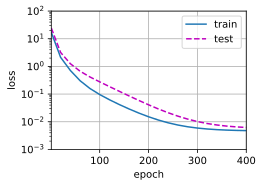

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### [**线性函数拟合(欠拟合)**]

让我们再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。


weight: [[2.702666  4.2259026]]


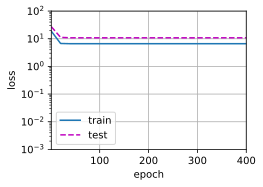

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### [**高阶多项式函数拟合(过拟合)**]

现在，让我们尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。


weight: [[ 4.9922      1.305686   -3.352961    5.116522   -0.11140402  1.3026645
   0.12679572  0.16638486  0.05130938 -0.02277358  0.00806421 -0.0516805
  -0.02426281 -0.01502219 -0.04941352  0.06389863 -0.04761845 -0.04380166
  -0.05188227  0.05655775]]


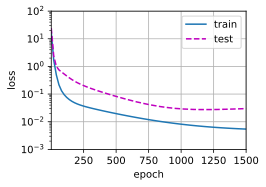

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

在接下来的章节中，我们将继续讨论过拟合问题和处理这些问题的方法，例如权重衰减和dropout。

## 小结

* 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
* 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
* 验证集可以用于模型选择，但不能过于随意地使用它。
* 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。

## 练习

1. 这个多项式回归问题可以准确地解出吗？提示：使用线性代数。
1. 考虑多项式的模型选择。
    1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
    1. 在这种情况下绘制测试的损失图。
    1. 生成同样的图，作为数据量的函数。
1. 如果不对多项式特征$x^i$进行标准化($1/i!$)，会发生什么事情？能用其他方法解决这个问题吗？
1. 泛化误差可能为零吗？


[Discussions](https://discuss.d2l.ai/t/1807)
